In [1]:
import os
import time
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

import allocation
import portfolio_summary
import utils as hrp_utils

In [2]:
import importlib
importlib.reload(allocation)
importlib.reload(hrp_utils)
importlib.reload(portfolio_summary)

<module 'portfolio_summary' from '/Users/vdp/projects/hierarchical_risk_parity/portfolio_summary.py'>

In [3]:
# directory information
CUR_DIR = os.getcwd()
DATA_FOLDER = os.path.join(CUR_DIR, "data")
ALL_DATA = os.path.join(DATA_FOLDER, "dataset.feather")

## Loading Data

#### NOTE: SNP Constituents are calculated at the start of the each year and remain the same for entire year

In [4]:
df = pd.read_feather(ALL_DATA)
df.head()

,date,ticker,permno,ret,mkt_cap,shrout,prc,year
0,2000-01-03,ROK,84381,0.031332,9392211.250,190222.0,49.3750,2000
1,2000-01-04,ROK,84381,-0.036709,9047433.875,190222.0,47.5625,2000
2,2000-01-05,ROK,84381,0.005256,9094989.375,190222.0,47.8125,2000
3,2000-01-06,ROK,84381,-0.016993,8940434.000,190222.0,47.0000,2000
4,2000-01-07,ROK,84381,0.027926,9190100.375,190222.0,48.3125,2000


#### Filtering for required data

In [5]:
data_df = df[["date", "permno", "ret", "year", "mkt_cap"]]
data_df.head()

,date,permno,ret,year,mkt_cap
0,2000-01-03,84381,0.031332,2000,9392211.250
1,2000-01-04,84381,-0.036709,2000,9047433.875
2,2000-01-05,84381,0.005256,2000,9094989.375
3,2000-01-06,84381,-0.016993,2000,8940434.000
4,2000-01-07,84381,0.027926,2000,9190100.375


#### Filtering for required data

In [6]:
data_df = data_df.groupby("year").apply(lambda x: hrp_utils.clean_dataset(x)).reset_index(drop=True)
data_df.head()

,date,permno,ret,year,mkt_cap
0,2000-01-03,84381,0.031332,2000,9392211.250
1,2000-01-04,84381,-0.036709,2000,9047433.875
2,2000-01-05,84381,0.005256,2000,9094989.375
3,2000-01-06,84381,-0.016993,2000,8940434.000
4,2000-01-07,84381,0.027926,2000,9190100.375


### Bases Cases: 
    1. Market weighted returns
    2. Equal weighted returns

In [7]:
mkt_df = data_df.drop_duplicates(subset=["year", "permno"], keep="last")[["year", "permno", "mkt_cap"]].reset_index(drop=True)
mkt_df["lag_mkt_cap"] =  mkt_df.groupby(["permno"])["mkt_cap"].shift()
mkt_df = mkt_df.dropna().reset_index(drop=True)
mkt_df.head()

,year,permno,mkt_cap,lag_mkt_cap
0,2001,84381,3.285829e+06,8.701516e+06
1,2001,81061,1.069640e+07,1.019093e+07
2,2001,85914,1.570485e+07,6.112195e+06
3,2001,21207,3.748044e+06,2.869930e+06
4,2001,87800,2.240735e+06,1.603648e+07


In [8]:
mkt_wgt_df = mkt_df.groupby("year").apply(lambda x: allocation.compute_mkt_weights(x)).reset_index()
eq_wgt_df = mkt_df.groupby("year").apply(lambda x: allocation.compute_unif_weights(x)).reset_index()

In [9]:
base_df = data_df.merge(mkt_wgt_df, on=["year", "permno"], how="left")
base_df = base_df[base_df["year"] > 2000]

base_df = base_df.merge(eq_wgt_df, on=["year", "permno"], how="left")
base_df["MKT_ret"] = base_df["ret"] * base_df["MKT"]
base_df["EQ_ret"] = base_df["ret"] * base_df["EQ"]

# daily returns of the portfolio
base_ret_df = base_df.groupby("date")["MKT_ret", "EQ_ret"].sum()
base_ret_df

,MKT_ret,EQ_ret
date,,
2001-01-02,-0.028877,-0.028219
2001-01-03,0.055665,0.046295
2001-01-04,-0.012854,-0.009114
2001-01-05,-0.025212,-0.020683
2001-01-08,-0.001344,0.002724
...,...,...
2022-12-23,0.004794,0.006778
2022-12-27,-0.007404,0.000080
2022-12-28,-0.011456,-0.013615


## Naive Risk Parity
#### Construction SNP500 portfolio with risk parity weighting and measuring the performance

In [10]:
%%time
test_df_lst = list()

for year in range(2001, 2023):
    test_df = data_df[data_df["year"] == year].set_index("permno")
    stocks = test_df.index
    
    form_df = data_df[data_df["year"] == (year - 1)]
    form_df = form_df[form_df["permno"].isin(stocks)]
    
    weights_list = list()
    rp_weight_df = allocation.compute_rp_weights(df=form_df).to_frame()
    
    test_df = rp_weight_df.join(test_df)

    test_df["RP_ret"] = test_df["ret"] * test_df["RP_wgt"]
    test_df_lst.append(test_df)

CPU times: user 7.57 s, sys: 3.76 s, total: 11.3 s
Wall time: 4.1 s


In [11]:
rp_ret_df = pd.concat(test_df_lst, ignore_index=True, axis=0)

rp_ret_df = rp_ret_df.groupby("date")["RP_ret"].sum().to_frame()
rp_ret_df

,RP_ret
date,
2001-01-02,-0.024337
2001-01-03,0.030016
2001-01-04,-0.011468
2001-01-05,-0.015479
2001-01-08,0.002536
...,...
2022-12-23,0.006510
2022-12-27,0.001231
2022-12-28,-0.012585


## HRP
#### Constructing SNP500 portfolio with HRP (single linkage) weighting

In [12]:
%%time
test_df_lst = list()
linkage_type = "single"

for year in range(2001, 2023):
    test_df = data_df[data_df["year"] == year].set_index("permno")
    stocks = test_df.index
    
    form_df = data_df[data_df["year"] == (year - 1)]
    form_df = form_df[form_df["permno"].isin(stocks)]
    
    weights_list = list()
    weight_df = allocation.compute_hrp_weights(df=form_df, linkage_type=linkage_type).to_frame()
    test_df = test_df.join(weight_df)

    wgt_ret = "HRP_" + linkage_type + "_ret"
    test_df[wgt_ret] = test_df["ret"] * test_df[f"HRP_{linkage_type}_wgt"]

    test_df_lst.append(test_df)

CPU times: user 34.4 s, sys: 24.9 s, total: 59.3 s
Wall time: 20.6 s


In [13]:
ret_df = pd.concat(test_df_lst, ignore_index=True, axis=0)

hrp_ret_df = ret_df.groupby("date")[wgt_ret].sum().to_frame()
hrp_ret_df

,HRP_single_ret
date,
2001-01-02,-0.022220
2001-01-03,0.016905
2001-01-04,-0.016400
2001-01-05,-0.009367
2001-01-08,0.003015
...,...
2022-12-23,0.005515
2022-12-27,0.001979
2022-12-28,-0.011654


### Merging various portfolios

In [14]:
final_ret_df = (base_ret_df.join(rp_ret_df)).join(hrp_ret_df)
final_ret_df.head()

,MKT_ret,EQ_ret,RP_ret,HRP_single_ret
date,,,,
2001-01-02,-0.028877,-0.028219,-0.024337,-0.022220
2001-01-03,0.055665,0.046295,0.030016,0.016905
2001-01-04,-0.012854,-0.009114,-0.011468,-0.016400
2001-01-05,-0.025212,-0.020683,-0.015479,-0.009367
2001-01-08,-0.001344,0.002724,0.002536,0.003015


#### Cumulative Returns

In [15]:
cum_final_ret_df = ((1 + final_ret_df).cumprod() - 1) * 100
cum_final_ret_df

,MKT_ret,EQ_ret,RP_ret,HRP_single_ret
date,,,,
2001-01-02,-2.887738,-2.821934,-2.433719,-2.222036
2001-01-03,2.517980,1.676893,0.494876,-0.569098
2001-01-04,1.200163,0.750259,-0.657582,-2.199741
2001-01-05,-1.351296,-1.333511,-2.195287,-3.115874
2001-01-08,-1.483894,-1.064699,-1.947243,-2.823791
...,...,...,...,...
2022-12-23,431.607867,840.348309,807.498081,771.618369
2022-12-27,427.671833,840.423787,808.614880,773.343287
2022-12-28,421.626720,827.620093,797.179852,763.165312


#### Plotting Cumulative Returns

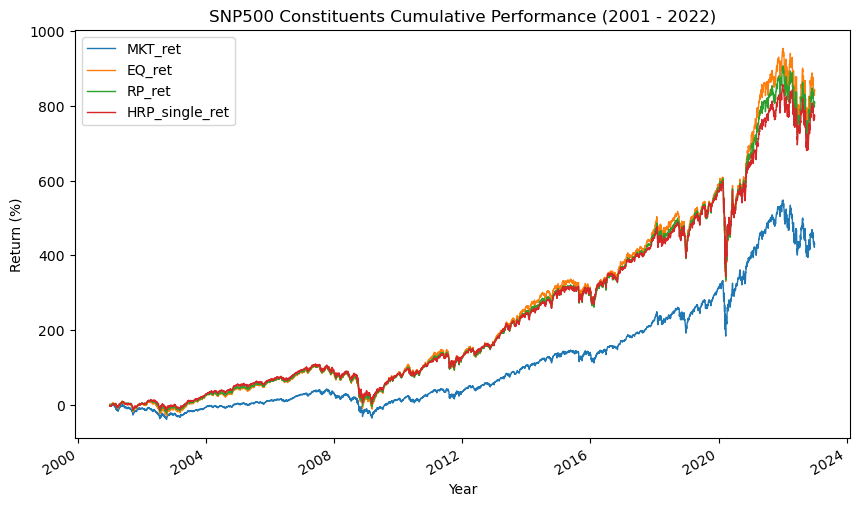

In [16]:
cum_final_ret_df.plot(figsize=(10,6), linewidth=1)

plt.title("SNP500 Constituents Cumulative Performance (2001 - 2022)")
plt.xlabel("Year")
plt.ylabel("Return (%)")
plt.show()

#### Deriving summary statistics to compare all cases

In [17]:
summary = (portfolio_summary.compute_portfolio_summary(final_ret_df))
summary

,CUM_RET (%),CAGR (%),MAR (%),ANN_VOL (%),SHARPE,TSTAT,MAX_DD (%)
MKT_ret,431.31,7.89,9.48,20.45,0.52,2.45,-54.28
EQ_ret,840.35,10.72,12.55,21.48,0.63,2.95,-57.19
RP_ret,807.55,10.55,12.03,19.79,0.67,3.16,-54.13
HRP_single_ret,771.68,10.34,11.55,17.77,0.72,3.37,-50.55
